# SARSA Trading Algorithm

This notebook implements the SARSA algorithm for portfolio trading on S&P 500 data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

## Data Loading and Processing

In [2]:
df = pd.read_csv("/home/youssouf/Downloads/archive/sp500_5yr.csv")

In [3]:
# Compute the index prices (volume-weighted average)
unique_symbols = df['Name'].unique()
new_df = {}
dates = None

for i, symbol in enumerate(unique_symbols):
    partial_df = df[df['Name'] == symbol].copy()
    partial_df = partial_df.sort_values(by='date')

    if partial_df.isna().sum().sum() > 0:
        continue
    if dates is None:
        dates = partial_df['date'].to_list()
        if len(dates) < 1259: 
            continue
    elif len(partial_df) < 1259:
        continue
    else:
        assert dates == partial_df['date'].to_list(), "Dates do not match across symbols"
    
    for col in ['open', 'high', 'low', 'close', 'volume']:
        new_df[col + f"-{symbol}"] = partial_df[col].to_list()

new_df = pd.DataFrame(new_df)

# Convert to float64
for col in new_df.columns:
    new_df[col] = new_df[col].astype(np.float64)

new_df['date'] = dates
new_df = new_df.set_index('date')

print(f"Processed data shape: {new_df.shape}")
print(f"Date range: {new_df.index[0]} to {new_df.index[-1]}")

Processed data shape: (1259, 2340)
Date range: 2013-02-08 to 2018-02-07


In [4]:
# Compute volume-weighted index prices
index_prices = pd.DataFrame()
volume_cols = new_df.filter(like='volume-')
total_volume = volume_cols.sum(axis=1)

for price_type in ['open', 'high', 'low', 'close']:
    price_cols = new_df.filter(like=f'{price_type}-')
    index_prices[price_type] = (price_cols.values * volume_cols.values).sum(axis=1) / total_volume.values

index_prices.index = new_df.index
print(f"Index prices shape: {index_prices.shape}")
index_prices.head()

Index prices shape: (1259, 4)


,open,high,low,close
date,,,,
2013-02-08,41.082020,41.500640,40.789177,41.207748
2013-02-11,40.832917,41.173278,40.513390,40.862581
2013-02-12,39.197571,39.582484,38.799817,39.161757
2013-02-13,38.675202,39.027626,38.276385,38.630306
2013-02-14,39.466134,40.028357,39.084703,39.634254


## SARSA Algorithm Implementation

### Trading Environment Setup

- **Portfolio states**: 0-10 representing percentage allocation to index (0% to 100% in 10% increments)
- **Actions**: 0=sell 10%, 1=hold, 2=buy 10%
- **State representation**: Discretized price features + current portfolio allocation
- **Reward**: Portfolio return for each action

In [5]:
class TradingEnvironment:
    def __init__(self, price_data, initial_cash=1000, window_size=10):
        self.price_data = price_data
        self.initial_cash = initial_cash
        self.window_size = window_size
        self.current_step = window_size
        self.portfolio_states = list(range(11))  # 0% to 100% in 10% increments
        self.actions = [0, 1, 2]  # sell, hold, buy
        self.reset()
    
    def reset(self):
        self.current_step = self.window_size
        self.portfolio_allocation = 5  # Start with 50% in index
        self.cash = self.initial_cash * 0.5
        self.shares = (self.initial_cash * 0.5) / self.price_data.iloc[self.current_step]['open']
        return self.get_state()
    
    def get_state(self):
        # Get recent price features
        recent_prices = self.price_data.iloc[self.current_step-self.window_size:self.current_step]
        
        # Calculate simple features
        price_changes = recent_prices['close'].pct_change().dropna()
        avg_change = price_changes.mean()
        volatility = price_changes.std()
        trend = 1 if recent_prices['close'].iloc[-1] > recent_prices['close'].iloc[0] else 0
        
        # Discretize features
        avg_change_discrete = min(4, max(0, int((avg_change + 0.02) * 50)))  # 5 levels
        volatility_discrete = min(4, max(0, int(volatility * 100)))  # 5 levels
        
        # Create state tuple
        state = (avg_change_discrete, volatility_discrete, trend, self.portfolio_allocation)
        return state
    
    def step(self, action):
        if self.current_step >= len(self.price_data) - 1:
            return self.get_state(), 0, True
        
        current_price = self.price_data.iloc[self.current_step]['open']
        
        # Execute action
        if action == 0:  # Sell 10%
            if self.portfolio_allocation > 0:
                sell_amount = min(self.shares, self.shares * 0.1)
                self.cash += sell_amount * current_price
                self.shares -= sell_amount
                self.portfolio_allocation = max(0, self.portfolio_allocation - 1)
        elif action == 2:  # Buy 10%
            if self.portfolio_allocation < 10:
                portfolio_value = self.cash + self.shares * current_price
                buy_amount = min(self.cash, portfolio_value * 0.1) / current_price
                self.cash -= buy_amount * current_price
                self.shares += buy_amount
                self.portfolio_allocation = min(10, self.portfolio_allocation + 1)
        # action == 1 (hold) requires no changes
        
        # Move to next step
        self.current_step += 1
        next_price = self.price_data.iloc[self.current_step]['close']
        
        # Calculate reward (portfolio return)
        portfolio_value = self.cash + self.shares * next_price
        prev_portfolio_value = self.cash + self.shares * current_price
        reward = (portfolio_value - prev_portfolio_value) / prev_portfolio_value
        
        done = self.current_step >= len(self.price_data) - 1
        
        return self.get_state(), reward, done
    
    def get_portfolio_value(self):
        current_price = self.price_data.iloc[self.current_step]['close']
        return self.cash + self.shares * current_price

# Create environment
env = TradingEnvironment(index_prices)
print(f"Environment created with {len(index_prices)} trading days")
print(f"Initial state: {env.get_state()}")

Environment created with 1259 trading days
Initial state: (0, 3, 0, 5)


In [6]:
class SARSAAgent:
    def __init__(self, actions, alpha=0.1, gamma=0.95, epsilon=0.1):
        self.actions = actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = defaultdict(lambda: np.zeros(len(actions)))
        
    def choose_action(self, state):
        if np.random.random() < self.epsilon:
            return np.random.choice(self.actions)
        else:
            return np.argmax(self.q_table[state])
    
    def update_q_value(self, state, action, reward, next_state, next_action):
        current_q = self.q_table[state][action]
        next_q = self.q_table[next_state][next_action]
        
        # SARSA update rule
        new_q = current_q + self.alpha * (reward + self.gamma * next_q - current_q)
        self.q_table[state][action] = new_q
    
    def decay_epsilon(self, decay_rate=0.995):
        self.epsilon = max(0.01, self.epsilon * decay_rate)

# Create SARSA agent
agent = SARSAAgent(env.actions)
print(f"SARSA agent created with {len(env.actions)} actions")

SARSA agent created with 3 actions


In [7]:
def train_sarsa(agent, env, episodes=500):
    episode_rewards = []
    portfolio_values = []
    
    for episode in range(episodes):
        state = env.reset()
        action = agent.choose_action(state)
        
        total_reward = 0
        done = False
        
        while not done:
            next_state, reward, done = env.step(action)
            
            if not done:
                next_action = agent.choose_action(next_state)
                agent.update_q_value(state, action, reward, next_state, next_action)
                
                state = next_state
                action = next_action
            
            total_reward += reward
        
        episode_rewards.append(total_reward)
        portfolio_values.append(env.get_portfolio_value())
        
        # Decay exploration
        agent.decay_epsilon()
        
        if episode % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:]) if len(episode_rewards) >= 100 else np.mean(episode_rewards)
            print(f"Episode {episode}, Avg Reward: {avg_reward:.6f}, "
                  f"Portfolio Value: ${portfolio_values[-1]:.2f}, "
                  f"Epsilon: {agent.epsilon:.3f}")
    
    return episode_rewards, portfolio_values

# Train the agent
print("Training SARSA agent...")
episode_rewards, portfolio_values = train_sarsa(agent, env, episodes=500)
print(f"\nTraining completed!")
print(f"Final portfolio value: ${portfolio_values[-1]:.2f}")
print(f"Total return: {(portfolio_values[-1] / 1000 - 1) * 100:.2f}%")

Training SARSA agent...
Episode 0, Avg Reward: 1.008043, Portfolio Value: $1484.34, Epsilon: 0.100
Episode 100, Avg Reward: 1.173179, Portfolio Value: $2219.36, Epsilon: 0.060
Episode 200, Avg Reward: 1.182266, Portfolio Value: $1820.94, Epsilon: 0.037
Episode 300, Avg Reward: 1.208453, Portfolio Value: $1859.94, Epsilon: 0.022
Episode 400, Avg Reward: 1.162920, Portfolio Value: $1677.51, Epsilon: 0.013

Training completed!
Final portfolio value: $1883.38
Total return: 88.34%


## Results Analysis

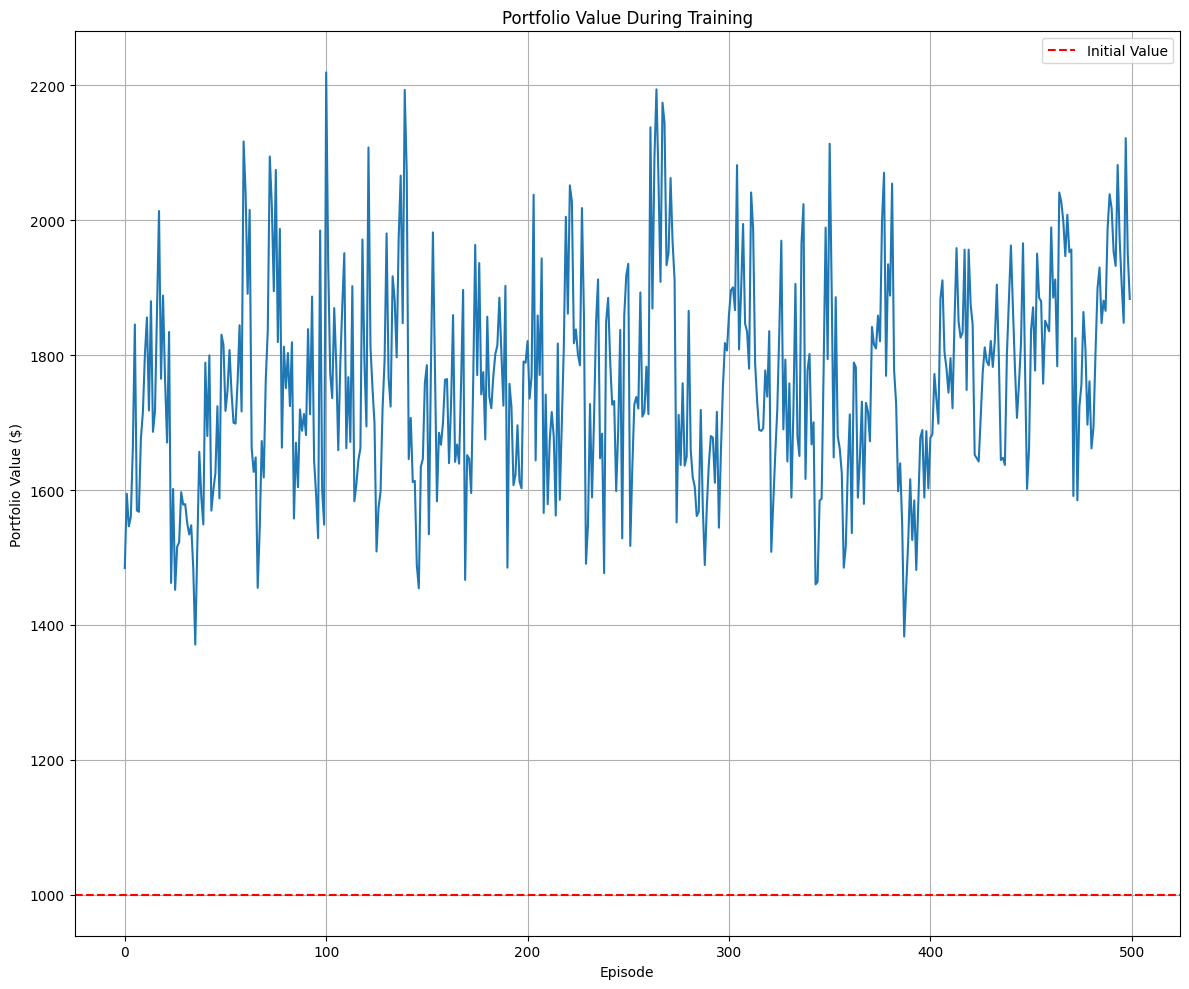


=== Training Statistics ===
Total episodes: 500
Average reward: 1.193723
Final portfolio value: $1883.38
Best portfolio value: $2219.36
Worst portfolio value: $1370.80
Total return: 88.34%
Number of states explored: 126


In [8]:
# Plot training progress
fig, (ax2) = plt.subplots(1, 1, figsize=(12, 10))

# Plot portfolio value
ax2.plot(portfolio_values)
ax2.axhline(y=1000, color='r', linestyle='--', label='Initial Value')
ax2.set_title('Portfolio Value During Training')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Portfolio Value ($)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print some statistics
print(f"\n=== Training Statistics ===")
print(f"Total episodes: {len(episode_rewards)}")
print(f"Average reward: {np.mean(episode_rewards):.6f}")
print(f"Final portfolio value: ${portfolio_values[-1]:.2f}")
print(f"Best portfolio value: ${max(portfolio_values):.2f}")
print(f"Worst portfolio value: ${min(portfolio_values):.2f}")
print(f"Total return: {(portfolio_values[-1] / 1000 - 1) * 100:.2f}%")
print(f"Number of states explored: {len(agent.q_table)}")

In [9]:
def test_agent(agent, env, episodes=10):
    """Test the trained agent with greedy policy (no exploration)"""
    original_epsilon = agent.epsilon
    agent.epsilon = 0  # No exploration during testing
    
    test_results = []
    
    for episode in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0
        actions_taken = []
        
        while not done:
            action = agent.choose_action(state)
            actions_taken.append(action)
            
            next_state, reward, done = env.step(action)
            total_reward += reward
            state = next_state
        
        final_value = env.get_portfolio_value()
        test_results.append({
            'episode': episode,
            'total_reward': total_reward,
            'final_value': final_value,
            'return_pct': (final_value / 1000 - 1) * 100,
            'actions': actions_taken
        })
    
    agent.epsilon = original_epsilon  # Restore original epsilon
    return test_results

# Test the trained agent
print("Testing trained agent...")
test_results = test_agent(agent, env, episodes=10)

print("\n=== Test Results ===")
for result in test_results:
    print(f"Episode {result['episode']}: "
          f"Return: {result['return_pct']:.2f}%, "
          f"Final Value: ${result['final_value']:.2f}")

avg_test_return = np.mean([r['return_pct'] for r in test_results])
print(f"\nAverage test return: {avg_test_return:.2f}%")

Testing trained agent...

=== Test Results ===
Episode 0: Return: 112.88%, Final Value: $2128.81
Episode 1: Return: 112.88%, Final Value: $2128.81
Episode 2: Return: 112.88%, Final Value: $2128.81
Episode 3: Return: 112.88%, Final Value: $2128.81
Episode 4: Return: 112.88%, Final Value: $2128.81
Episode 5: Return: 112.88%, Final Value: $2128.81
Episode 6: Return: 112.88%, Final Value: $2128.81
Episode 7: Return: 112.88%, Final Value: $2128.81
Episode 8: Return: 112.88%, Final Value: $2128.81
Episode 9: Return: 112.88%, Final Value: $2128.81

Average test return: 112.88%


In [10]:
# Analyze the learned policy
print("\n=== Learned Policy Analysis ===")
print(f"Number of states in Q-table: {len(agent.q_table)}")

# Show some example Q-values
print("\nSample Q-values (first 10 states):")
print("State -> [Sell, Hold, Buy]")
for i, (state, q_values) in enumerate(list(agent.q_table.items())[:10]):
    best_action = np.argmax(q_values)
    action_names = ['Sell', 'Hold', 'Buy']
    print(f"{state} -> {q_values} (Best: {action_names[best_action]})")

# Count action preferences
action_counts = {'Sell': 0, 'Hold': 0, 'Buy': 0}
action_names = ['Sell', 'Hold', 'Buy']

for state, q_values in agent.q_table.items():
    best_action = np.argmax(q_values)
    action_counts[action_names[best_action]] += 1

print(f"\nAction preferences across all states:")
for action, count in action_counts.items():
    percentage = (count / len(agent.q_table)) * 100
    print(f"{action}: {count} states ({percentage:.1f}%)")


=== Learned Policy Analysis ===
Number of states in Q-table: 126

Sample Q-values (first 10 states):
State -> [Sell, Hold, Buy]
(0, 3, 0, 5) -> [0.02741285 0.01702752 0.01103251] (Best: Sell)
(0, 3, 0, 4) -> [0.01639194 0.00445847 0.01589981] (Best: Sell)
(1, 2, 1, 3) -> [ 0.00750886 -0.00552378 -0.00253197] (Best: Sell)
(1, 2, 1, 4) -> [0.00419583 0.01236933 0.0004646 ] (Best: Hold)
(1, 2, 1, 5) -> [0.01648717 0.00226267 0.0025488 ] (Best: Sell)
(0, 2, 0, 4) -> [0.03196141 0.00833868 0.01390051] (Best: Sell)
(1, 3, 1, 3) -> [ 0.00761927  0.00127345 -0.00537593] (Best: Sell)
(0, 3, 0, 3) -> [0.03109309 0.01119511 0.01183075] (Best: Sell)
(1, 3, 1, 2) -> [0.01984126 0.00627288 0.00683704] (Best: Sell)
(1, 3, 1, 1) -> [0.00301348 0.0042753  0.01483493] (Best: Buy)

Action preferences across all states:
Sell: 64 states (50.8%)
Hold: 41 states (32.5%)
Buy: 21 states (16.7%)


In [11]:
# Compare with buy-and-hold strategy
def buy_and_hold_benchmark(price_data, initial_cash=1000):
    """Calculate buy-and-hold returns"""
    initial_price = price_data.iloc[10]['open']  # Start from same point as agent
    final_price = price_data.iloc[-1]['close']
    
    shares = initial_cash / initial_price
    final_value = shares * final_price
    
    return final_value, (final_value / initial_cash - 1) * 100

bh_value, bh_return = buy_and_hold_benchmark(index_prices)

print(f"\n=== Performance Comparison ===")
print(f"Buy-and-Hold:")
print(f"  Final value: ${bh_value:.2f}")
print(f"  Return: {bh_return:.2f}%")
print(f"\nSARSA Agent (average test performance):")
print(f"  Final value: ${np.mean([r['final_value'] for r in test_results]):.2f}")
print(f"  Return: {avg_test_return:.2f}%")
print(f"\nDifference: {avg_test_return - bh_return:.2f} percentage points")

if avg_test_return > bh_return:
    print("✓ SARSA agent outperformed buy-and-hold!")
else:
    print("✗ SARSA agent underperformed buy-and-hold")


=== Performance Comparison ===
Buy-and-Hold:
  Final value: $1847.67
  Return: 84.77%

SARSA Agent (average test performance):
  Final value: $2128.81
  Return: 112.88%

Difference: 28.11 percentage points
✓ SARSA agent outperformed buy-and-hold!
